In [1]:
import os
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/',
    image_size=(150, 150),
    batch_size=150,
    subset='training',
    validation_split=0.2,
    seed=1234
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/',
    image_size=(150, 150),
    batch_size=150,
    subset='validation',
    validation_split=0.2,
    seed=1234
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


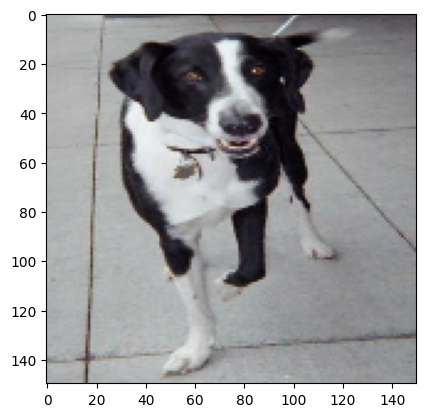

In [3]:
for i, correct in train_ds.take(1):
    plt.imshow(i[0].numpy().astype('uint8'))
    plt.show()

In [4]:
def datasetting(i, correct):
    i = tf.cast(i / 255.0, tf.float32)
    return i, correct

train_ds = train_ds.map(datasetting)
val_ds = val_ds.map(datasetting)

## Transfer learning

In [5]:
import requests

url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
r = requests.get(url, allow_redirects=True)

open('inception_v3.h5', 'wb').write(r.content)

87910968

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [7]:
inception_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)
inception_model.load_weights('inception_v3.h5')

inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [10]:
for i in inception_model.layers:
    i.trainable = False

unfreeze = False
for i in inception_model.layers:
    if i.name == 'mixed6':
        unfreeze = True
    if unfreeze == True:
        i.trainable = True

last_layer = inception_model.get_layer('mixed7')

print(last_layer)
print(last_layer.output_shape)

(None, 7, 7, 768)


In [11]:
layer1 = tf.keras.layers.Flatten()(last_layer.output)
layer2 = tf.keras.layers.Dense(1024, activation='relu')(layer1)
drop1 = tf.keras.layers.Dropout(0.2)(layer2)
layer3 = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)

model = tf.keras.Model(inception_model.input, layer3)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00001), metrics=['acc'])
model.fit(train_ds, validation_data=val_ds, epochs=2)

Epoch 1/2
  7/134 [>.............................] - ETA: 6:12 - loss: 1.9968 - acc: 0.6676

KeyboardInterrupt: 